In [1]:
import pandas as pd

In [2]:
# Load the data from CSV file to pandas dataframe
df1 = pd.read_csv('/Users/uddeepawijerathna/Documents/MSc/1st_sem/data_science/analysis_project/1.csv')
df2 = pd.read_csv('/Users/uddeepawijerathna/Documents/MSc/1st_sem/data_science/analysis_project/2.csv')

In [3]:
# Combined two datasets
df_combined = pd.concat([df1, df2])

# Drop the lines with no value
df_combined = df_combined.dropna(subset=['ftt'])
# Change type of the ftt and defects column
df_combined['ftt'] = df_combined['ftt'].astype(int)

df_combined = df_combined.dropna(subset=['defects'])
df_combined['defects'] = df_combined['defects'].astype(int)
df_combined.head()

,session_date,shift_dn,module_id,buyer,style,product_type,issue_name,operation_name,defects,checked_pcs,reworked,ftt
0,2022-12-01,Pagi,Line 02,H&M,6308BN7-B,SHORTS,Benang_panjang / Untrimmed_thread,PASANG BIBIR BOBOK DEPAN + LAPISAN,10,680,26.0,654
1,2022-12-01,Pagi,Line 02,H&M,6308BN7-B,SHORTS,Jahitan_jarum_2_tidak_rata / Uneven_double_nee...,PASANG PINGGANG + TANDA,8,680,26.0,654
2,2022-12-01,Pagi,Line 02,H&M,6308BN7-B,SHORTS,Jahitan_jebol / Open_seam,SAMBUNG SAMPING,3,680,26.0,654
3,2022-12-01,Pagi,Line 02,H&M,6308BN7-B,SHORTS,Jahitan_putus / Broken_stitches,OVERDECK PINGGANG KELILING,3,680,26.0,654
4,2022-12-01,Pagi,Line 02,H&M,6308BN7-B,SHORTS,Jahitan_loncat / Skip_stitching,OVERDECK UJUNG KAKI,2,680,26.0,654


In [4]:
# Calculate percentage of FTT items without defects
# get the unique values of the 'ftt' column and try to sum them up
ftt = df_combined['ftt'].sum()
checked_pcs = df_combined['checked_pcs'].sum()
print(ftt)
print(checked_pcs)


551009
727929


In [5]:
# convert session_date column to datetime
df_combined['session_date'] = pd.to_datetime(df_combined['session_date'])
df_combined['month'] = df_combined['session_date'].dt.strftime('%B')

# group by month and module_id(production line)
grouped = df_combined.groupby([pd.Grouper(key='session_date', freq='M'), 'module_id', 'month'])

# get the first item of each group for checked_pcs
first_checked_pcs = grouped['checked_pcs'].first()

# get the first item of each group for reworked
first_reworked = grouped['reworked'].first()

# get the first item of each group for ftt
first_ftt = grouped['ftt'].first()

In [6]:
# create a new DataFrame
df_new = pd.DataFrame({
    'module_id': first_checked_pcs.index.get_level_values(1),
    'session_date': first_checked_pcs.index.get_level_values(0),
    'checked_pcs': first_checked_pcs.values,
    'reworked': first_reworked.values,
    'ftt': first_ftt.values,
    'month':first_checked_pcs.index.get_level_values(2)
})

df_new = df_new.groupby(pd.Grouper(key='month')).sum()
print(df_new)

          checked_pcs  reworked   ftt
month                                
December         3984     104.0  3669
January          3779      72.0  2186


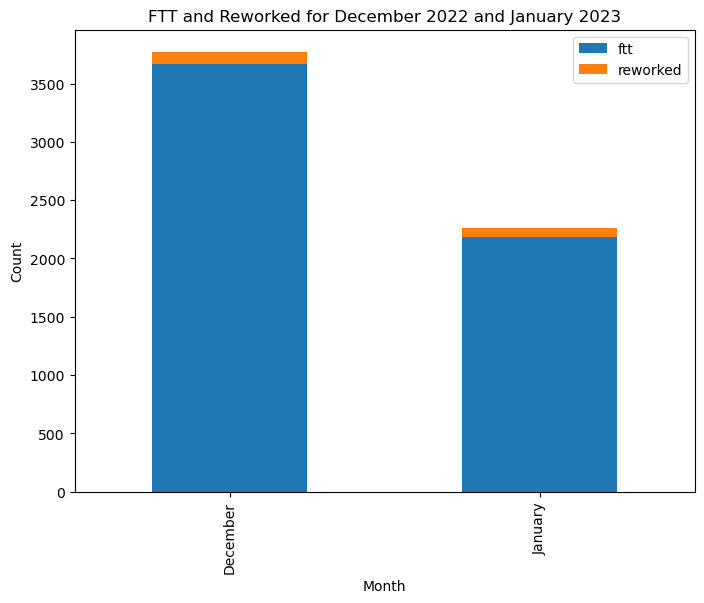

In [7]:
import matplotlib.pyplot as plt

# plot FTT and Reworked as columns
ax = df_new[['ftt', 'reworked']].plot(kind='bar', stacked=True, figsize=(8, 6))
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('FTT and Reworked for December 2022 and January 2023')
plt.show()

In [8]:
# Calculate ftt (without defects) percentage for a month

df_new['ftt_percentage'] = df_new['ftt'] / df_new['checked_pcs'] * 100
print(df_new)

          checked_pcs  reworked   ftt  ftt_percentage
month                                                
December         3984     104.0  3669       92.093373
January          3779      72.0  2186       57.845991


In [9]:
# Calculate reworked percentage for a month
df_new['reworked_percentage'] = df_new['reworked'] / df_new['checked_pcs'] * 100
print(df_new)

          checked_pcs  reworked   ftt  ftt_percentage  reworked_percentage
month                                                                     
December         3984     104.0  3669       92.093373             2.610442
January          3779      72.0  2186       57.845991             1.905266


In [10]:
# Identify the difficult operations on a garment that causes lot of defects.

# convert session_date column to datetime
df_combined['session_date'] = pd.to_datetime(df_combined['session_date'])
df_combined['month'] = df_combined['session_date'].dt.strftime('%B')

# group by month and module_id(production line)
grouped = df_combined.groupby([pd.Grouper(key='session_date', freq='M'), 'module_id'])

# Create a new DataFrame by applying an anonymous function that returns the original DataFrame
df_new = grouped.apply(lambda x: x[['month', 'operation_name', 'defects']])
df_new = df_new.sort_values(['month', 'defects'], ascending=[True, False])
print(df_new)


        month                 operation_name  defects
511  December                SAMBUNG SMAPING       25
143  December        PASANG PINGGANG + TANDA       15
198  December        PASANG PINGGANG + TANDA       15
256  December        PASANG PINGGANG + TANDA       15
329  December        PASANG PINGGANG + TANDA       15
..        ...                            ...      ...
470   January  PASANG KARET PINGGANG + TANDA        1
471   January               OVERDECK SAMPING        1
472   January  PASANG KARET PINGGANG + TANDA        1
473   January           PASANG BOBOK SAMPING        1
474   January                SAMBUNG SAMPING        1

[1066 rows x 3 columns]


In [11]:
# Identify the shift time when lot of defects are generated.
# convert session_date column to datetime
df_combined['session_date'] = pd.to_datetime(df_combined['session_date'])
df_combined['month'] = df_combined['session_date'].dt.strftime('%B')

# group by month and module_id(production line)
grouped = df_combined.groupby([pd.Grouper(key='session_date', freq='M'), 'module_id'])

# Create a new DataFrame by applying an anonymous function that returns the original DataFrame
df_new = grouped.apply(lambda x: x[['month', 'shift_dn','operation_name', 'defects']])
df_new = df_new.sort_values(['month', 'shift_dn','defects'], ascending=[True, True,False])
print(df_new)

        month shift_dn                 operation_name  defects
511  December     Pagi                SAMBUNG SMAPING       25
452  December     Pagi             TINDIK BOBOK DEPAN       15
482  December     Pagi                SAMBUNG SMAPING       15
548  December     Pagi                SAMBUNG SMAPING       15
586  December     Pagi                SAMBUNG SMAPING       15
..        ...      ...                            ...      ...
470   January     Pagi  PASANG KARET PINGGANG + TANDA        1
471   January     Pagi               OVERDECK SAMPING        1
472   January     Pagi  PASANG KARET PINGGANG + TANDA        1
473   January     Pagi           PASANG BOBOK SAMPING        1
474   January     Pagi                SAMBUNG SAMPING        1

[1066 rows x 4 columns]


In [12]:
# convert session_date column to datetime
df_combined['session_date'] = pd.to_datetime(df_combined['session_date'])
df_combined['month'] = df_combined['session_date'].dt.strftime('%B')

# group by month and module_id(production line)
grouped = df_combined.groupby([pd.Grouper(key='session_date', freq='M'), 'month','shift_dn'])

df_new = grouped['defects'].sum().reset_index()

print(df_new)


  session_date     month shift_dn  defects
0   2022-12-31  December     Pagi     1271
1   2022-12-31  December    Siang      594
2   2023-01-31   January     Pagi     1196


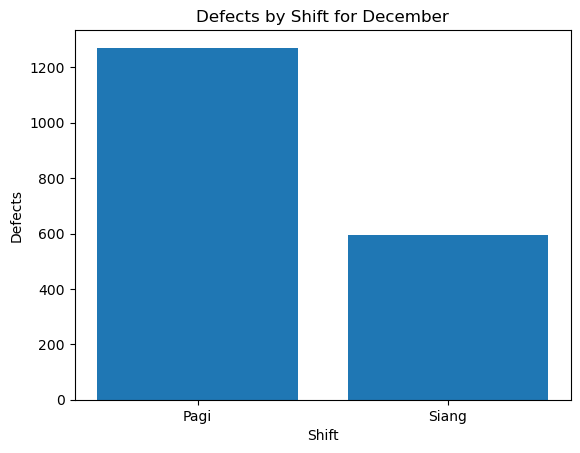

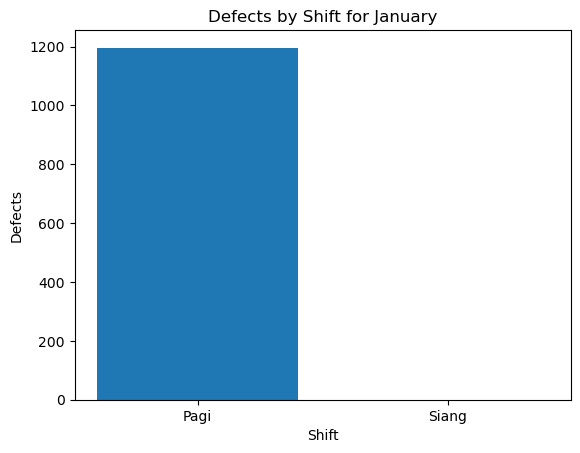

In [13]:
import matplotlib.pyplot as plt

# create a list of the unique months in the data
months = ['December', 'January']
# create a bar chart for each month
for month in months:   

    result1 = df_new.loc[(df_new['month'] == month) & (df_new['shift_dn'] == 'Pagi')]['defects']
    if result1.empty:
        pagi_defects=0
    else:
        pagi_defects = result1.values[0]

    result2 = df_new.loc[(df_new['month'] == month) & (df_new['shift_dn'] == 'Siang')]['defects']
    if result2.empty:
        siang_defects=0
    else:
        siang_defects = result2.values[0]
    
    
    # create a bar chart with two bars for each shift_dn
    fig, ax = plt.subplots()
    ax.bar(['Pagi', 'Siang'],[pagi_defects, siang_defects])
    ax.set_title(f'Defects by Shift for {month}')
    ax.set_xlabel('Shift')
    ax.set_ylabel('Defects')
    plt.show()